<a href="https://colab.research.google.com/github/SalvatoreAdalberto/mlapp/blob/main/3_ML_bof_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Histological image classification leveraging Bag Of Features

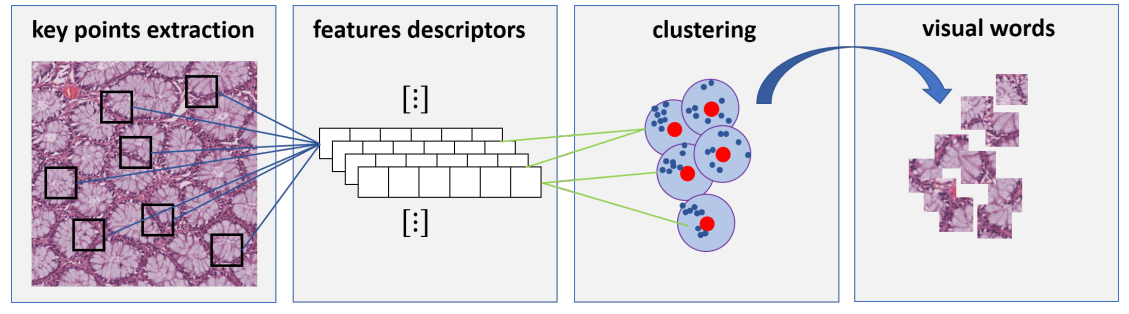

## Import and settings

In [1]:
import os
import cv2
import glob
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
!git clone https://github.com/frpnz/dataset-BIOSTEC2018.git
ROOTDIR_DATASET = "/content/dataset-BIOSTEC2018/crc_images"

Cloning into 'dataset-BIOSTEC2018'...
remote: Enumerating objects: 13518, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 13518 (delta 1), reused 6 (delta 1), pack-reused 13512
Receiving objects: 100% (13518/13518), 1.87 GiB | 24.72 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (13501/13501), done.


## Utils
The well-know function to plot a nice confusion matrix

In [3]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

Write a class to handle the dataset. 
Such class must return a dict with 

*   key = class
*   value = list of tuples (image, filepath)

Where image is a numpy array of shape (90, 90, 3). Hence, the images must be resized. See functions in [OpenCV-Python](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html), a library of Python bindings designed to solve computer vision problem.

In [4]:
class Dataset:
    def __init__(self, path):
        self.path = path

    def getFiles(self):
        """
        returns a dict with key = object_name and value = list of tuples (image, filepath)
        """
        image_dict = dict()
        for subdir in glob.glob(f"{self.path}/*/", recursive=False):
            word = os.path.basename(os.path.normpath(subdir))
            image_dict[word] = list()
            for image_file in glob.glob(f"{subdir}/*", recursive=False):
                image = cv2.imread(image_file, 1)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (90, 90))
                image_dict[word].append((image, image_file))
        return image_dict

In [5]:
path_train = os.path.join(ROOTDIR_DATASET, "train")
dataset = Dataset(path_train)
dataset_train = dataset.getFiles()

In [8]:
dataset_train.keys()

dict_keys(['AD', 'AC', 'H'])

# Assignment #1: Plot some random images to ensure the images to be correctly loaded. 
This should be their aspect.

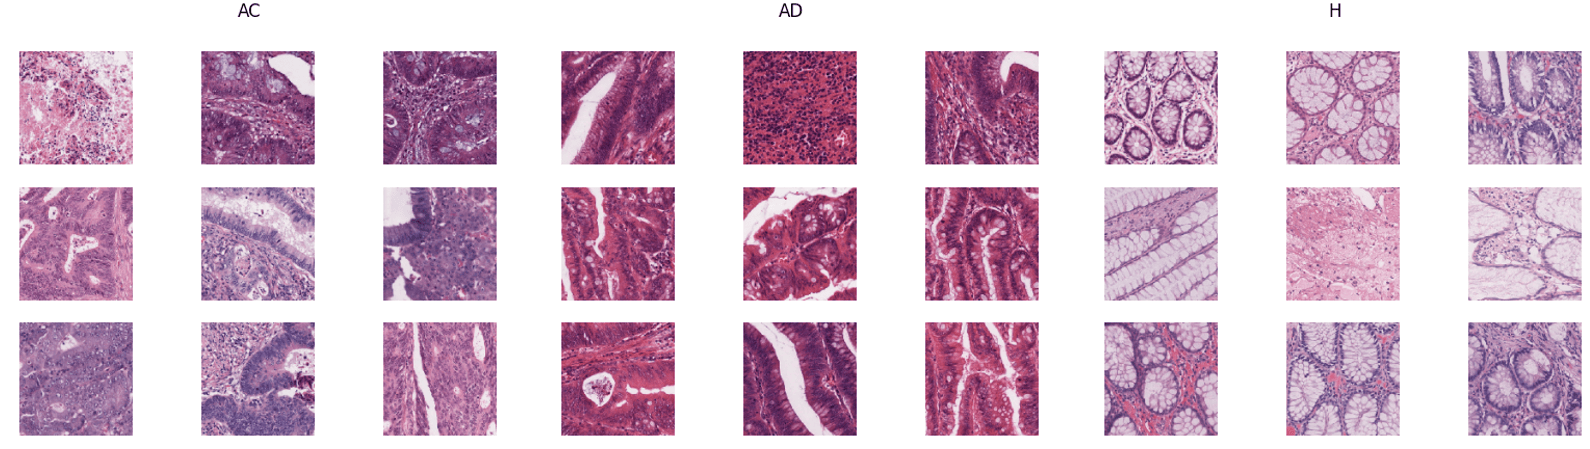

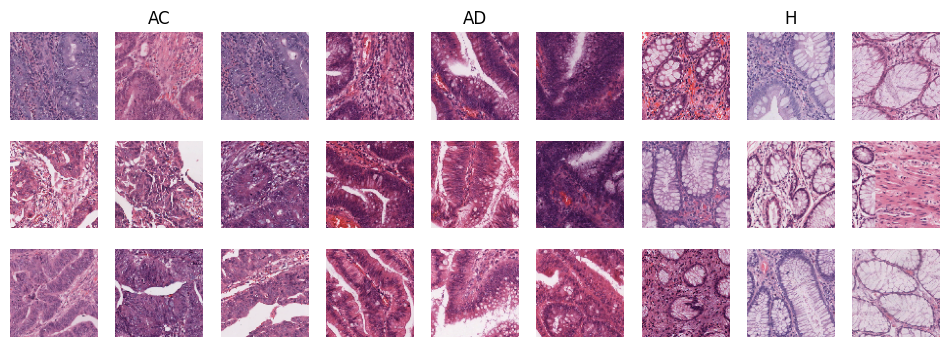

In [9]:
import random

fig, axs = plt.subplots(nrows=3, ncols=9, figsize=(12, 4))
axs = np.array(axs).ravel(order='F')
mapping = {0: 'AC', 1: 'AD', 2: 'H'}
for i, ax in enumerate(axs):
  label = mapping[i//9]
  # print(f"label = {label}")
  # print(f"{type(dataset_train[label])}")
  img = random.choice(dataset_train[label])[0]
  ax.imshow(img)
  if i == 3:
    ax.set_title(label)
  elif i == 12:
    ax.set_title(label)
  elif i == 21:
    ax.set_title(label)
  ax.axis('off')
fig.show()

In [6]:
class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]

Extract SIFT descriptors for all the images. See an example [here]
(https://vovkos.github.io/doxyrest-showcase/opencv/sphinxdoc/page_tutorial_py_sift_intro.html)

Using SIFT, we detect and extract features inside each image. SIFT through OPENCV returns us a  `m x 128` dimension array, where `m` is the number of features extrapolated. Note that `m changes among different images`, depending on which features are detected. In some extreme cases (specifically when the image resolution is lower than 128x128) I experienced to get no detected features at all for some images.

In [7]:
# extract SIFT Features from each image
class Descriptors:
    def __init__(self, dataset):
        self.dataset = dataset
        self.im_helper = ImageHelpers()
    
    def GetDescriptors(self):
        labels = list()
        descriptor_list = list()
        name_dict = dict()
        label_count = 0
        for word, imlist in self.dataset.items():
            name_dict[label_count] = word
            for im, filepath in imlist:
                kp, des = self.im_helper.features(im)
                if des is None:
                    print(f"Cannot extract SIFT for {filepath}.")
                    continue
                descriptor_list.append(des)
                labels.append(label_count)
            label_count += 1
        return descriptor_list, labels, name_dict

# Assignment #2: # reshape list into np array of shape K samples x 128 features for sklearn



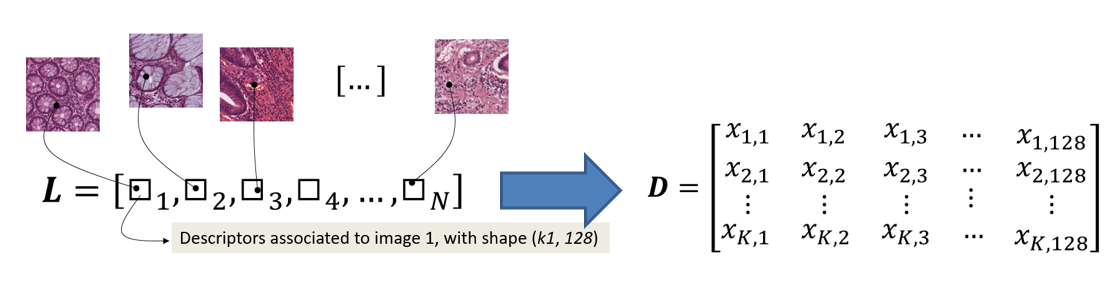

In [10]:
descriptors = Descriptors(dataset_train).GetDescriptors()

In [11]:
ds_list, labels, name_mapping = descriptors

d = np.vstack(ds_list)
d.shape

(915095, 128)

# Assignment #3: Construction of the visual vocabulary by k-means clustering (see sklarn)
May require some time depending on the input resolution (~ 6/7 mins for 70x70 RGB images).

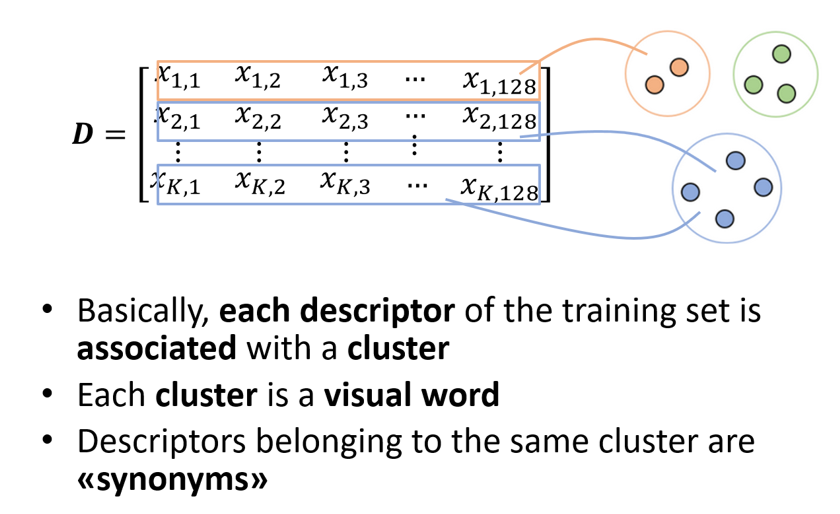

In [12]:
n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(d)

In [13]:
kmeans.labels_

array([12,  5, 12, ..., 16, 15,  2], dtype=int32)

# Assignment #4: Build the histogram of the visual words


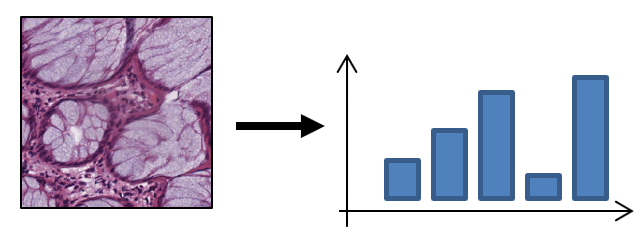

In [15]:
def MakeHistogram(descriptors_list, n_clusters, kmeans_pred):
  result = np.zeros(shape=(len(descriptors_list), n_clusters))
  count = 0
  for i, img in enumerate(descriptors_list):
    n_of_descriptors = len(img)
    for j in range(n_of_descriptors):
      visual_word_idx = kmeans_pred[count + j]
      result[i][visual_word_idx] += 1
    count += n_of_descriptors
  return result

## Assignment #4.1: Scale the histogram of the visual words

In [16]:
histogram_train = MakeHistogram(ds_list, n_clusters, kmeans.labels_)

print(histogram_train.shape)
scaler = preprocessing.StandardScaler()
histogram_train_scaled = scaler.fit_transform(histogram_train)

(9000, 20)


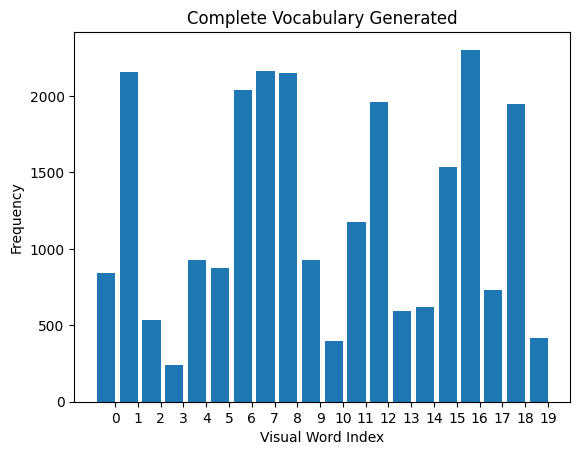

In [17]:
x_scalar = np.arange(n_clusters)
y_scalar = np.array([abs(np.sum(histogram_train_scaled[:,h], dtype=np.int32)) for h in range(n_clusters)])
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.title("Complete Vocabulary Generated")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

# Assignment #5: Train and then test an SVM on the histogram of the visual words

In [14]:
random_grid_svm = {
    "kernel": ["rbf", "poly", "sigmoid"],
    "gamma": ["scale", "auto", 0.0001, 0.001, 0.01, 0.1],
    "degree": [2, 3, 4, 5],
    "class_weight": [None, "balanced"],
    "C": [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 500, 1000]
}

search = RandomizedSearchCV(estimator=SVC(), param_distributions=random_grid_svm, scoring="balanced_accuracy", n_iter=10, cv=3, verbose =1)

In [18]:
search.fit(histogram_train_scaled, labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20,
                                              50, 100, 500, 1000],
                                        'class_weight': [None, 'balanced'],
                                        'degree': [2, 3, 4, 5],
                                        'gamma': ['scale', 'auto', 0.0001,
                                                  0.001, 0.01, 0.1],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   scoring='balanced_accuracy', verbose=1)

In [19]:
classifier = search.best_estimator_

In [20]:
def evaluate(classifier, data, label):
    prediction = classifier.predict(data)
    cm = confusion_matrix(label, prediction)
    fig, ax = plt.subplots(figsize=(4,4))
    seaborn_cm(cm, ax, tick_labels=['AC', 'AD', 'H'])

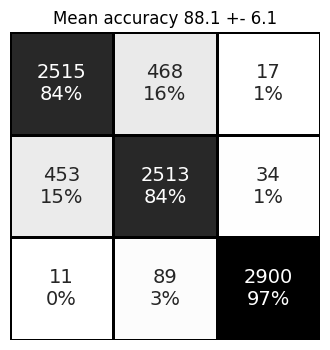

In [21]:
evaluate(classifier, histogram_train_scaled, labels)

## Test the model

In [22]:
path_test = os.path.join(ROOTDIR_DATASET, "test")
dataset = Dataset(path_test)
dataset_test = dataset.getFiles()

ds_test, labels_test, _ = Descriptors(dataset_test).GetDescriptors()
descriptors_test = np.vstack(ds_test)

In [23]:
descriptors_test.shape

(489074, 128)

In [25]:
n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(descriptors_test)
histogram_test = MakeHistogram(ds_test, n_clusters, kmeans.labels_)

histogram_test_scaled = scaler.transform(histogram_test)

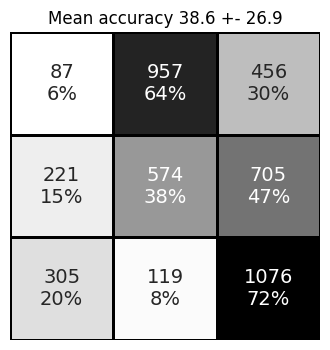

In [26]:
evaluate(classifier, histogram_test_scaled, labels_test)